In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
import accelerate
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms
import typing as tp
import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()
torch_device = "cuda"

In [13]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2 - 1)
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [75]:
from tqdm import tqdm

@torch.no_grad()
def magic_mix(image_path: str, text: str, nu: float = 0.75, total_steps: int = 100, guidance: float = 8) -> tp.List[PIL.Image.Image]:
    image = Image.open(image_path).resize((512, 512))
    scheduler.set_timesteps(total_steps) # global num_train_timesteps is divided into total_steps
    
    t_min = round(0.3 * total_steps) # 15
    t_max = round(0.6 * total_steps) # 30
    
    layout_steps = list(range(total_steps - t_max, total_steps - t_min)) # [20, 21, 22 .. 35]
    rest = list(range(total_steps - t_min, total_steps))
    
    prompt = tokenizer(text, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    prompt_emb = text_encoder(prompt.input_ids.to(torch_device))[0]
    
    max_length = prompt.input_ids.shape[-1]
    uncond = tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt")
    
    uncond_emb = text_encoder(uncond.input_ids.to(torch_device))[0]
    text_emb = torch.cat([uncond_emb, prompt_emb]) # by rows
    
    encoded = pil_to_latent(image)
    noise = torch.randn_like(encoded)
    
    fine_tuned = None
    for i in tqdm(layout_steps):
        t = scheduler.timesteps[i]
        noisy_lat = scheduler.add_noise(encoded, noise, torch.tensor([t]))
        
        if fine_tuned is not None:
            noisy_lat = nu * fine_tuned + (1 - nu) * noisy_lat
            
        model_input = torch.cat([noisy_lat] * 2)
        model_input = scheduler.scale_model_input(model_input, t)
        
        noise_pred = unet(model_input, t, encoder_hidden_states=text_emb).sample
        noise_pred_uncond, noise_pred_text = torch.chunk(noise_pred, 2)
        noise_pred = noise_pred_uncond + guidance * (noise_pred_text - noise_pred_uncond)
        
        fine_tuned = scheduler.step(noise_pred, t, noisy_lat).prev_sample
        
    after_layout = fine_tuned
    
    for i in tqdm(rest):
        t = scheduler.timesteps[i]
        model_input = torch.cat([after_layout] * 2)
        model_input = scheduler.scale_model_input(model_input, t)

        noise_pred = unet(model_input, t, encoder_hidden_states=text_emb).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance * (noise_pred_text - noise_pred_uncond)

        after_layout = scheduler.step(noise_pred, t, after_layout).prev_sample

    return latents_to_pil(after_layout)[0]
        
        

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9949  100  9949    0     0   118k      0 --:--:-- --:--:-- --:--:--  117k


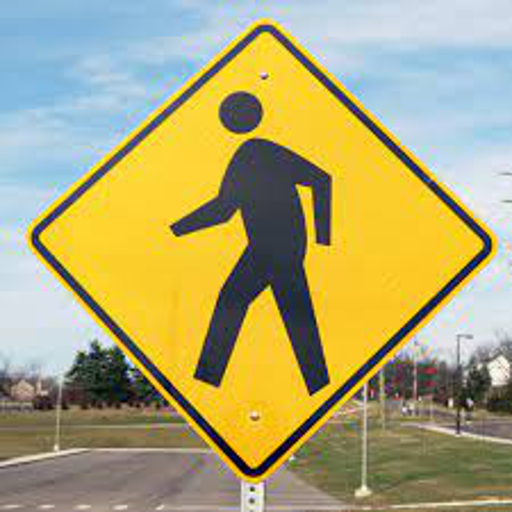

In [77]:
!curl --output sign.jpg 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRvDWbGWcMhgHrPO03JbiXA-xoKiULJ5CdBQTHBnfXAZhZSJevQKeQB1vk0_HxHmiDwjuA&usqp=CAU'
input_image = Image.open('sign.jpg').resize((512, 512))
input_image

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.41it/s]


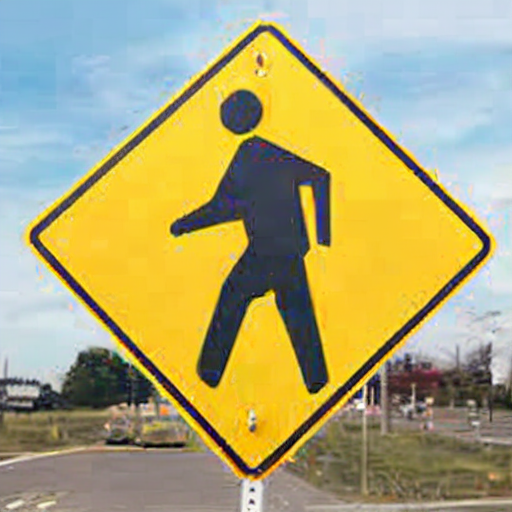

In [80]:
magic_mix('sign.jpg', 'traffic sign of flowers')